# DBSCAN
This notebook is split into three sections with one for every algorithm.
Essentially, the idea is to cluster movies and users so that we can
recommend the entire cluster they belong to, for both users and movies.

Compared to the other algorithms, this means that we will not be able
to give exactly how much they like a given movie, but just give them
the cluster they reside in.

## Initialise PySpark and data

In [3]:
from random import random
import time

from sklearn.decomposition import PCA
from pyspark.ml.linalg import DenseVector
from pyspark.mllib.random import RandomRDDs
import pyspark.sql
import pyspark
import pandas as pd
from pyspark import SparkContext, SparkConf, SQLContext
from sklearn.cluster import DBSCAN
import os
import numpy as np

from density.slides_dbscan import my_DBSCAN

if os.path.basename(os.getcwd()) == 'density':
    print("Current dir is", os.getcwd())
    print("Changing dir to be in root")
    os.chdir('..')
    print('now in', os.getcwd())

from proposal.useful_tools import pickle_manager

SPARK_CONF = SparkConf()
SPARK_CONF.set("spark.driver.memory", "10g")
SPARK_CONF.set("spark.cores.max", "4")
SPARK_CONF.set("spark.executor.heartbeatInterval", "3600")
SPARK_CONF.setAppName("word2vec")

SPARK_CONTEXT = SparkContext.getOrCreate(SPARK_CONF)
SPARK = SQLContext(SPARK_CONTEXT)

np.random.seed(42)

Current dir is E:\Users\nicol\Documents\GitHub\3804ICT-Data-mining-try-4\density
Changing dir to be in root
now in E:\Users\nicol\Documents\GitHub\3804ICT-Data-mining-try-4


In [4]:
# Assume that I can do this
MOVIES: pd.DataFrame = pickle_manager.load_pickle(
    'pickles/sentences.pickle.lz4'
)
print(MOVIES.head())

MOVIES_FEATURES: pd.DataFrame = pickle_manager.load_pickle(
    'pickles/sentence_features.pickle.lz4'
)
print(MOVIES_FEATURES.head())
MOVIES_FEATURES = MOVIES_FEATURES.reset_index().to_numpy(dtype=np.float64)

# Huh apparently we have nan. If we set to 0 then it should be fine
MOVIES_FEATURES[np.isnan(MOVIES_FEATURES)] = 0
print(MOVIES_FEATURES)

pca_maker = PCA(n_components=2)
PCA_DATA = pca_maker.fit_transform(MOVIES_FEATURES)
print(PCA_DATA)

      imdbId                        title  \
0  tt0000009                   Miss Jerry   
1  tt0000574  The Story of the Kelly Gang   
2  tt0001892               Den sorte drøm   
3  tt0002101                    Cleopatra   
4  tt0002130                    L'Inferno   

                                         description  \
0   The adventures of a female reporter in the 1890s   
1  True story of notorious Australian outlaw Ned ...   
2  Two men of high rank are both wooing the beaut...   
3  The fabled queen of Egypt's affair with Roman ...   
4  Loosely adapted from Dante's Divine Comedy and...   

                               processed_description  
0                   [adventur, femal, report, 1890s]  
1  [true, stori, notori, australian, outlaw, ned,...  
2  [two, men, high, rank, woo, beauti, famous, eq...  
3  [fabl, queen, egypt, affair, roman, general, m...  
4  [loos, adapt, dant, divin, comedi, inspir, ill...  
         0         1         2         3         4         5  

In [5]:
unzipped_PCA_DATA = list(zip(*PCA_DATA))

PCA_x, PCA_y = unzipped_PCA_DATA[0], unzipped_PCA_DATA[1]
print(PCA_DATA[0])

[-4.29270000e+04  2.42203179e-01]


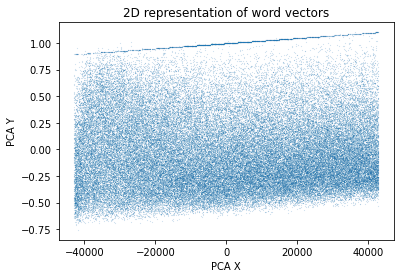

In [6]:
import matplotlib.pyplot as plt

plt.scatter(PCA_x, PCA_y, s=0.005)
plt.title("2D representation of word vectors")
plt.xlabel("PCA X")
plt.ylabel("PCA Y")
plt.show()

So we actually have a pretty cool way to represent clusters visually by doing this! Ideally we can break
this into chunks of movies with 100 or so recommendations. In theory, it should not just turn brown, but it
might.

## Finding Optimal Parameters
To be safe with defining epsilon and radius, it was decided that the library
will be used first. This can let us just train for the optimal
epsilon and minimum samples while knowing it works.

If you open a website for movies, you probably want to see at least 100 movies.
Let's assume that's our minimum number of points then.

In [7]:
# This is probably going to light up as copied from somewhere
MIN_POINTS = 100

from sklearn.neighbors import NearestNeighbors

start = time.perf_counter()
neighbors = NearestNeighbors(n_neighbors=MIN_POINTS)
neighbors_fit = neighbors.fit(MOVIES_FEATURES)
distances, indices = neighbors_fit.kneighbors(MOVIES_FEATURES)
print("That took", time.perf_counter() - start)

That took 14.608202900000009


25.070127915020123
[[    0     1     2 ...    97    98    99]
 [    1     0     2 ...    97    98    99]
 [    2     3     1 ...    97    98    99]
 ...
 [85852 85853 85851 ... 85757 85756 85755]
 [85853 85852 85854 ... 85757 85756 85755]
 [85854 85853 85852 ... 85757 85756 85755]]
(100,)
max 99.00732891662456
min 50.0
mean 50.040675067492536
median 50.0118111231062


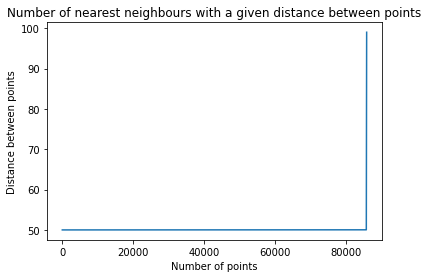

In [8]:
print(np.average(distances))
print(indices)
print(distances[0].shape)

max_neighbours_distances = distances[:, -1]
max_neighbours_distances = np.sort(max_neighbours_distances)

max = np.max(max_neighbours_distances)
min = np.min(max_neighbours_distances)
average = np.average(max_neighbours_distances)
median = np.median(max_neighbours_distances)

print('max', np.max(max_neighbours_distances))
print('min', np.min(max_neighbours_distances))
print('mean', np.average(max_neighbours_distances))
print('median', np.median(max_neighbours_distances))

plt.plot(max_neighbours_distances)
plt.title('Number of nearest neighbours with a given distance between points')
plt.xlabel('Number of points')
plt.ylabel('Distance between points')
plt.show()

Our ideal value for epsilon is going to be sitting right at that turn in the centre. Most
people just eye the value, but we can actually just use the second derivative to find this point.

First issue is that this is not a continuous function, so we are going to have to find the
discrete form of how to find the second derivative.

Taking the derivative by first principle:
$$
    \frac{dy}{dx} = \lim_{h \rightarrow 0} \frac{f(x+h) - f(x)}{h}
$$

Now to convert this to discrete values, we know that h does exist and cannot
be infinitely close to 0 anymore. Instead, we are forced to select this distance
by the space between the points, which should be 1 in our case.

For our second derivative, we have to find the derivative of the values around the point
then the derivative of those changes. So we do:

In [9]:
maximum_curve = 0
maximum_curve_index = 0

# We need to use the point in front and behind so we need
# to start at 1 and end one early
for i in range(500, len(max_neighbours_distances) - 1):
    a_to_b = max_neighbours_distances[i - 1] - max_neighbours_distances[i]
    b_to_c = max_neighbours_distances[i + 1] - max_neighbours_distances[i]
    second_derivative = b_to_c - a_to_b
    if i == 1:
        maximum_curve = second_derivative
        maximum_curve_index = 1

    if second_derivative > maximum_curve:
        maximum_curve = second_derivative
        maximum_curve_index = i

In [10]:
print("Maximum curvature occurs at", maximum_curve_index)
epsilon = max_neighbours_distances[maximum_curve_index]
print("That distance is", epsilon)

Maximum curvature occurs at 85761
That distance is 53.00965234322805


Now that is a lot of possible inflections. Odds are that a lot of them are between 0 and 20,000 and 80,000
for us though.

## Scikit DBSCAN
[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN)
### Implementation

In [11]:
start = time.perf_counter()
scikit_movies_clustering = DBSCAN(
    eps=epsilon, min_samples=MIN_POINTS
).fit(MOVIES_FEATURES)
print("Took", time.perf_counter() - start, "seconds")

Took 22.275545500000007 seconds


In [12]:
def count_noise(labels):
    count = 0
    for i in labels:
        if i == -1:
            count += 1
    return count


print(scikit_movies_clustering.labels_)
print("Unique labels", set(scikit_movies_clustering.labels_))
print("Number of noise points", count_noise(scikit_movies_clustering.labels_))

print("Frequency table", np.unique(np.unique(scikit_movies_clustering.labels_, return_counts=True)))

[0 0 0 ... 0 0 0]
Unique labels {0}
Number of noise points 0
Frequency table [    0 85855]


That's not a great outcome. Let's try a couple more potential values that were chosen earlier

In [17]:
from sklearn import metrics

def evaluate_measurement(name, epsilon):
    print("========= Trying", name, epsilon, "==============")
    start = time.perf_counter()
    scikit_movies_clustering = DBSCAN(
        eps=epsilon, min_samples=MIN_POINTS
    ).fit(MOVIES_FEATURES)
    print("Took", time.perf_counter() - start, "seconds")

    print("Number of clusters",
          len(set(scikit_movies_clustering.labels_)) - (1 if -1 in scikit_movies_clustering.labels_ else 0))
    print("Noise fraction", list(scikit_movies_clustering.labels_).count(-1) / len(scikit_movies_clustering.labels_))
    print("Frequency table", np.unique(scikit_movies_clustering.labels_, return_counts=True))

# This takes a long time to calculate so its left out for now
# print("Silhouette Coefficient", metrics.silhouette_score(MOVIES_FEATURES, scikit_movies_clustering.labels_))

In [18]:
try_out = {
    'min on max_neighbours': np.min(max_neighbours_distances),
    'average on max_neighbours': np.average(max_neighbours_distances),
    'median on max_neighbours': np.median(max_neighbours_distances),
    'average on all distances': np.average(distances),
    'median on all distances': np.median(distances),
}

for key, value in try_out.items():
    evaluate_measurement(key, value)

========= Trying min on max_neighbours 50.0 ==============
Took 21.19948389999996 seconds
Number of clusters 54
Noise fraction 0.9014850620231786
Frequency table (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53], dtype=int64), array([77397,   149,   149,   149,   149,   149,   199,   157,   149,
         149,   149,   149,   149,   149,   149,   149,   232,   154,
         149,   149,   246,   149,   149,   149,   149,   149,   149,
         149,   149,   149,   149,   149,   149,   149,   149,   195,
         149,   149,   149,   149,   149,   149,   235,   220,   115,
         149,   149,   149,   149,   149,   149,   149,   149,   149,
         149], dtype=int64))
========= Trying average on max_neighbours 50.040675067492536 ==============
Took 20.451109799999983 seconds
Number of cluste

In [37]:
# Try out  a number below 50 as well
evaluate_measurement('below 50', 49.99)

========= Trying below 50 49.99 ==============
Took 20.28809000000001 seconds
Number of clusters 0
Noise fraction 1.0
Frequency table (array([-1], dtype=int64), array([85855], dtype=int64))


# Moving Forwards
So overall we can see that this is not a very functional idea. A distance of 50 gives us 54 clusters and mostly noise,
but then if we take it up to 50.01 then that noise is all crushed into a single cluster anyways. Let's quickly make a
graph for that 54 cluster group to visualise how its working out:

In [32]:
import matplotlib as mpl

def make_plot(dbscan, pca_x, pca_y):
    N = len(np.unique(dbscan.labels_))
    print(N, "labels")
    colour_map = plt.cm.jet
    colour_map_list = [colour_map(i) for i in range(colour_map.N)]
    colour_map = colour_map.from_list('Neat colours', colour_map_list, colour_map.N)

    bounds = np.linspace(0, N, N+1)
    norm = mpl.colors.BoundaryNorm(bounds, colour_map.N)

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    scatter = ax.scatter(pca_x, pca_y, c=dbscan.labels_, cmap=colour_map, s=0.005, norm=norm)
    cb = plt.colorbar(scatter, spacing='proportional', ticks=bounds)
    cb.set_label('Cluster colours')

    ax.set_title('Clusters')
    ax.set_xlabel('pca x')
    ax.set_ylabel('pca y')

    plt.show()

55 labels


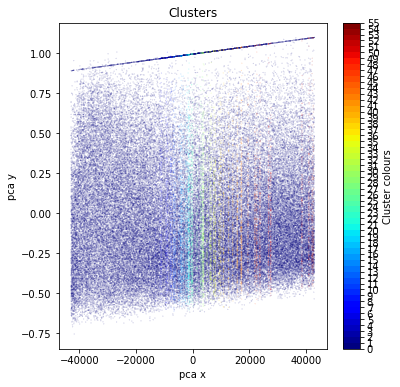

In [35]:
# Min was 50
make_plot(
    DBSCAN(
        eps=np.min(max_neighbours_distances), min_samples=MIN_POINTS
    ).fit(MOVIES_FEATURES), PCA_x, PCA_y
)

2 labels


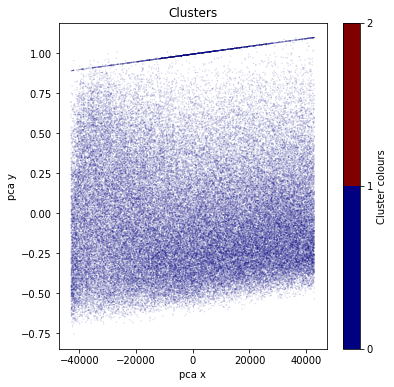

In [38]:
# Median was 50.04
make_plot(
    DBSCAN(
        eps=np.median(max_neighbours_distances), min_samples=MIN_POINTS
    ).fit(MOVIES_FEATURES), PCA_x, PCA_y
)

Well, that looks cool, but it highlights the problem. We can see that at 50.01 we have a couple of very small
clusters, then at 50.04 it makes everything into one cluster. So let's try out using the data that was generated for
knn

In [ ]:
    print("==============================")
print("Doing", i)

start = time.perf_counter()
scikit_movies_clustering = DBSCAN(
    eps=i, min_samples=5, n_jobs=-1, metric='cosine'
).fit(MOVIES_FEATURES)
print("Took", time.perf_counter() - start, "seconds")

print(scikit_movies_clustering.labels_)
print("Unique labels", set(scikit_movies_clustering.labels_))
print("Number of noise points", count_noise(scikit_movies_clustering.labels_))

print("Frequency table", np.unique(np.unique(scikit_movies_clustering.labels_, return_counts=True)))


## PyClustering DBSCAN
### [Documentation](https://pyclustering.github.io/docs/0.10.1/html/d2/d42/classpyclustering_1_1cluster_1_1dbscan_1_1dbscan.html#details)

from pyclustering.cluster.dbscan import dbscan

start = time.perf_counter()
pyclustering_movies = dbscan(
    MOVIES_SIMILARITY_MATRIX, MOVIES_RADIUS, MOVIES_MINIMUM_POINTS, True, **{'data_type': 'distance_matrix'}
)
pyclustering_movies.process()
print("Took", time.perf_counter() - start, "seconds")

print("Clusters:", pyclustering_movies.get_clusters())
print("Noise:", pyclustering_movies.get_noise())
print("Number of noise points", len(pyclustering_movies.get_noise()))
print("Frequency table", np.unique(np.unique(pyclustering_movies.get_clusters(), return_counts=True)))

## Slides
### Implementation
Since we made a class that just inherits the scikit dbscan and replaces the fit function, we should
just be able to do the same process here as the scikit section

start = time.perf_counter()
my_dbscan_movies_clustering = my_DBSCAN(
    eps=MOVIES_RADIUS, min_samples=MOVIES_MINIMUM_POINTS, metric='precomputed', n_jobs=-1
).fit(MOVIES_SIMILARITY_MATRIX.copy())
print("Took", time.perf_counter() - start, "seconds")

print(set(my_dbscan_movies_clustering.labels_))
print("Number of noise points", count_noise(my_dbscan_movies_clustering.labels_))
print("Frequency table", np.unique(np.unique(my_dbscan_movies_clustering.labels_, return_counts=True)))

## Evaluation



def evaluate_clustering_numerically(labels, features):
    """
    All of the prints that are needed to represent how well the data is clustered
    :param labels:
    :return:
    """
    print("Number of clusters", len(set(labels)) - (1 if -1 in labels else 0))
    print("Noise fraction", list(labels).count(-1) / len(labels))
    print("Silhouette Coefficient", metrics.silhouette_score(features, labels))

evaluate_clustering_numerically(
    scikit_movies_clustering.labels_,
    MOVIES_FEATURES
)

evaluate_clustering_numerically(
    pyclustering_movies.get_clusters(),
    MOVIES_SIMILARITY_MATRIX
)

evaluate_clustering_numerically(
    my_dbscan_movies_clustering.labels_,
    MOVIES_SIMILARITY_MATRIX
)